In [19]:
!gdown --id 1hXzB6JOW9BczQmuIPYmNbGoI6aSdz2VS #baseline dataset
!gdown --id 1Ijj9IrYxr_8E6auPazrHjQLbPZKwC36J #baseline network
!gdown --id 1b8rd3IZmwygeuh3EdZ6wufzhN5fxt7NE #baseline utils
!gdown --id 1XfV8pVN39Rwl--2wI2rQ1paZSV4N1VsY #Glove
!gdown --id 1cQnxpWJwSUitkzX5mOiNpuF33poY2mR- #Annotation File
!unzip Glove.zip
!unzip /content/annotation_file.zip

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1hXzB6JOW9BczQmuIPYmNbGoI6aSdz2VS
To: /content/baseline_dataset.py
100% 4.25k/4.25k [00:00<00:00, 5.66MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Ijj9IrYxr_8E6auPazrHjQLbPZKwC36J
To: /content/baseline_network.py
100% 1.50k/1.50k [00:00<00:00, 2.70MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Download

In [3]:
!pip install contractions

     |████████████████████████████████| 287 kB 9.8 MB/s 
     |████████████████████████████████| 106 kB 65.0 MB/s 


In [1]:
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from baseline_dataset import *
from baseline_network import *
from baseline_utils import *

In [5]:
roletolabel = {'hero' : 0, 'villain' : 1, 'victim' : 2, 'other' : 3}
path = "./Glove/glove.6B.100d.txt"
vocab , embeddings_np = embedding(path)

In [6]:
train_df = pd.read_csv("./annotation_file/train.csv")
train_df

,Name,Text,Entity,Role
0,covid_memes_252.png,kwai\ngkwa 0964\n#nnevvy\napplause to Thais fr...,thais,hero
1,covid_memes_20.png,best candidate for\nJA\n2020\njoe biden\nKamal...,joe biden,hero
2,covid_memes_60.png,MASK\nTRUMP\nTRUMP\nDEN CE\nHelp your child fi...,donald trump,hero
3,covid_memes_493.png,BARACK OBAMA PRESENTS\nA MEDAL TO HIMSELF.\nFO...,barack obama,hero
4,covid_memes_321.png,*New Swine flu like virus with\nhuman pandemic...,china,hero
...,...,...,...,...
17523,memes_982.png,Biden-Obama\nMemes\n300. Funny & Hillarious\nM...,biden obama meme,other
17524,memes_982.png,Biden-Obama\nMemes\n300. Funny & Hillarious\nM...,john robinson,other
17525,memes_982.png,Biden-Obama\nMemes\n300. Funny & Hillarious\nM...,memes,other
17526,memes_982.png,Biden-Obama\nMemes\n300. Funny & Hillarious\nM...,joe biden,other


In [7]:
labels, count = np.unique(train_df['Role'], return_counts = True)
print(labels, count)

['hero' 'other' 'victim' 'villain'] [  471 13713   903  2441]


In [8]:
class_weights = [sum(count)/ c for c in count ]
class_weights

[37.21443736730361, 1.278203164880041, 19.410852713178294, 7.180663662433429]

In [9]:
train_df['Role'] = train_df['Role'].map({'hero' : 0, 'villain' : 1, 'victim' : 2, 'other' : 3})

In [10]:
dataset = Custom(None, r"/content/annotation_file/train.csv", vocab, None, freq_threshold = 3, roletolabel = roletolabel)
pad_idx = dataset.vocab.stoi["<PAD>"]
example_weights = [class_weights[e] for e in train_df['Role']]
sampler = torch.utils.data.WeightedRandomSampler(example_weights, 9000)
loader = DataLoader(dataset=dataset, batch_size = 512, num_workers = 0, pin_memory=True, 
                    collate_fn = MyCollate(pad_idx = pad_idx), drop_last = False, sampler = sampler)

In [11]:
dataset = Custom(None, r"/content/annotation_file/val.csv", vocab, None, freq_threshold = 3, roletolabel = roletolabel)
pad_idx = dataset.vocab.stoi["<PAD>"]

val_loader = DataLoader(dataset=dataset, batch_size = 512, num_workers = 0, shuffle=True, pin_memory=True, 
                    collate_fn = MyCollate(pad_idx = pad_idx), drop_last = False)

In [27]:
model = Model(no_layers = 2, embs_weigth = embeddings_np, dimensions = 128, no_of_classes = 4).to(device)

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = 3e-3, weight_decay = 1e-3)

100%|██████████| 18/18 [00:10<00:00,  1.64it/s]


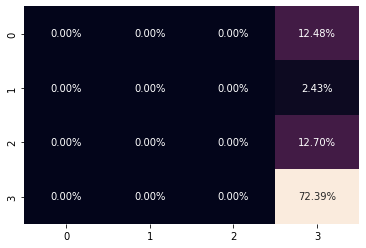

100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


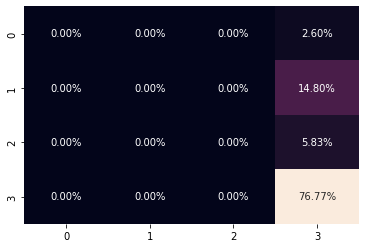


Epoch 1
Training Loss: 1.0035211741924286 -----> Training Accuracy: 72.38888888888889 %, Training F1 Score : 0.20995810505961973
Validation Loss: 1.0073672771453857 -----> Validation Accuracy: 76.7710843373494 %, Validation F1 Score : 0.21714830970556162
Validation F1 Inreased(-inf ---> 0.2171) 	 Saving The Model


100%|██████████| 18/18 [00:11<00:00,  1.63it/s]


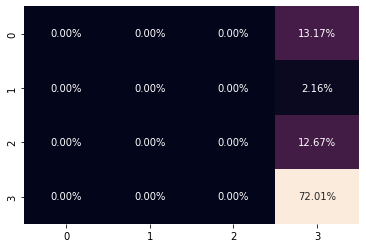

100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


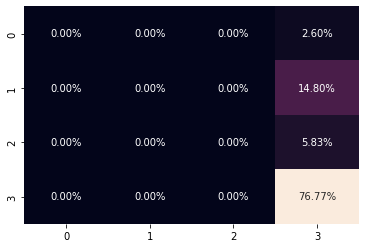


Epoch 2
Training Loss: 0.849565949704912 -----> Training Accuracy: 72.0111111111111 %, Training F1 Score : 0.2093211032879013
Validation Loss: 0.9682530999183655 -----> Validation Accuracy: 76.7710843373494 %, Validation F1 Score : 0.21714830970556162


100%|██████████| 18/18 [00:11<00:00,  1.62it/s]


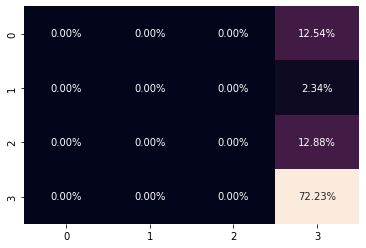

100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


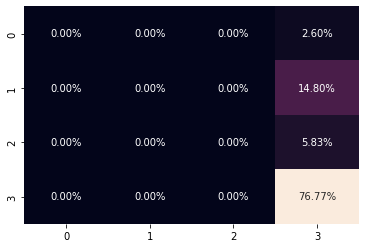


Epoch 3
Training Loss: 0.8492618401845297 -----> Training Accuracy: 72.23333333333333 %, Training F1 Score : 0.20969614863557193
Validation Loss: 1.007658016681671 -----> Validation Accuracy: 76.7710843373494 %, Validation F1 Score : 0.21714830970556162


100%|██████████| 18/18 [00:10<00:00,  1.64it/s]


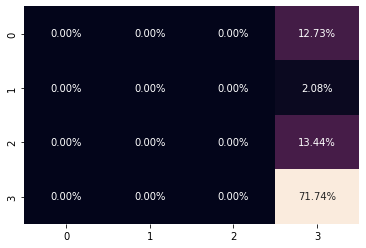

100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


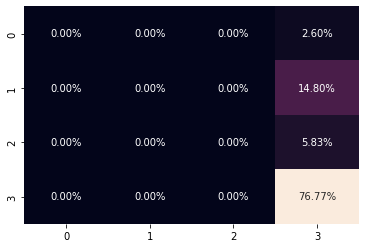


Epoch 4
Training Loss: 0.8242873681916131 -----> Training Accuracy: 71.74444444444444 %, Training F1 Score : 0.20886976774277027
Validation Loss: 0.9537141919136047 -----> Validation Accuracy: 76.7710843373494 %, Validation F1 Score : 0.21714830970556162


100%|██████████| 18/18 [00:10<00:00,  1.64it/s]


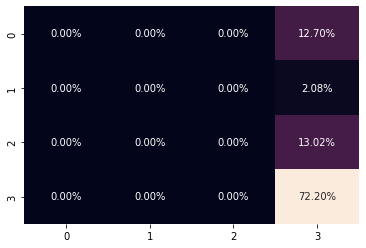

100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


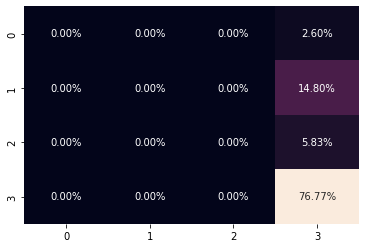


Epoch 5
Training Loss: 0.7854008807076348 -----> Training Accuracy: 72.2 %, Training F1 Score : 0.20963995354239257
Validation Loss: 0.9579851865768433 -----> Validation Accuracy: 76.7710843373494 %, Validation F1 Score : 0.21714830970556162


100%|██████████| 18/18 [00:10<00:00,  1.64it/s]


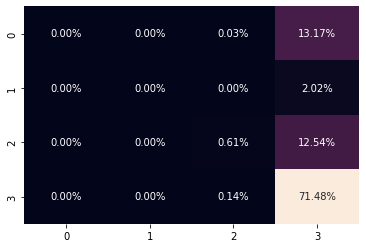

100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


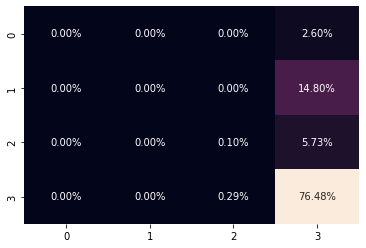


Epoch 6
Training Loss: 0.7884677681658003 -----> Training Accuracy: 72.08888888888889 %, Training F1 Score : 0.23111560263012987
Validation Loss: 0.9278494596481324 -----> Validation Accuracy: 76.57831325301204 %, Validation F1 Score : 0.2245552166730207
Validation F1 Inreased(0.2171 ---> 0.2246) 	 Saving The Model


100%|██████████| 18/18 [00:10<00:00,  1.65it/s]


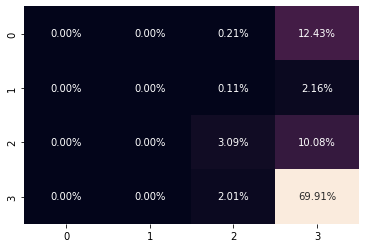

100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


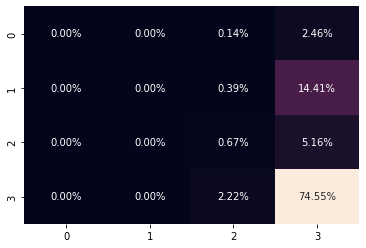


Epoch 7
Training Loss: 0.765857090552648 -----> Training Accuracy: 73.0 %, Training F1 Score : 0.29302755634694266
Validation Loss: 0.9589823007583618 -----> Validation Accuracy: 75.2289156626506 %, Validation F1 Score : 0.25149864470391997
Validation F1 Inreased(0.2246 ---> 0.2515) 	 Saving The Model


100%|██████████| 18/18 [00:10<00:00,  1.66it/s]


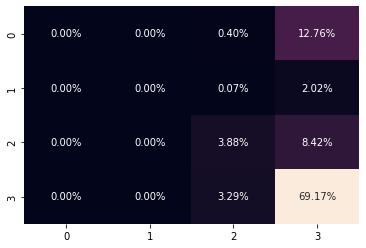

100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


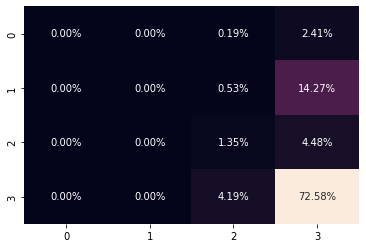


Epoch 8
Training Loss: 0.7721710668669807 -----> Training Accuracy: 73.04444444444445 %, Training F1 Score : 0.30709070382617054
Validation Loss: 0.9462010741233826 -----> Validation Accuracy: 73.92771084337349 %, Validation F1 Score : 0.2686090009661749
Validation F1 Inreased(0.2515 ---> 0.2686) 	 Saving The Model


100%|██████████| 18/18 [00:11<00:00,  1.63it/s]


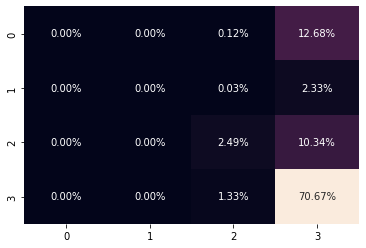

100%|██████████| 5/5 [00:03<00:00,  1.67it/s]


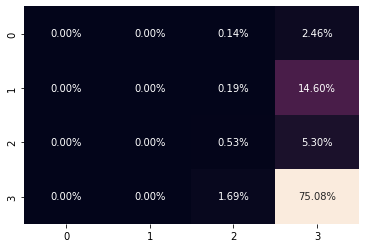


Epoch 9
Training Loss: 0.7462524606121911 -----> Training Accuracy: 73.15555555555555 %, Training F1 Score : 0.28431475989119737
Validation Loss: 0.9133095383644104 -----> Validation Accuracy: 75.6144578313253 %, Validation F1 Score : 0.2471002050841799


100%|██████████| 18/18 [00:11<00:00,  1.63it/s]


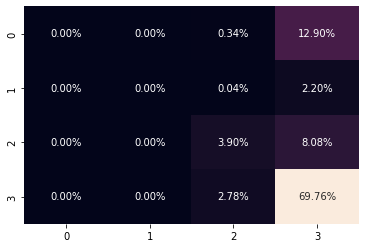

100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


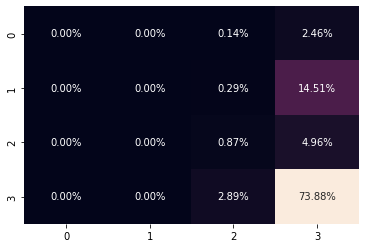


Epoch 10
Training Loss: 0.7322254379590353 -----> Training Accuracy: 73.65555555555555 %, Training F1 Score : 0.31317637906971424
Validation Loss: 0.9225873112678528 -----> Validation Accuracy: 74.74698795180723 %, Validation F1 Score : 0.2573155865357764


100%|██████████| 18/18 [00:11<00:00,  1.63it/s]


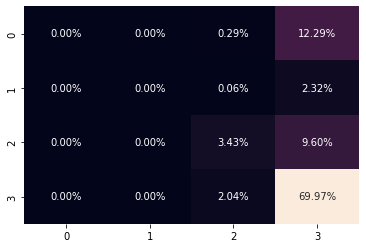

100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


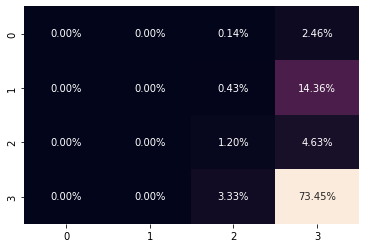


Epoch 11
Training Loss: 0.7266659835974375 -----> Training Accuracy: 73.4 %, Training F1 Score : 0.3015464602928316
Validation Loss: 0.9424731731414795 -----> Validation Accuracy: 74.65060240963855 %, Validation F1 Score : 0.26899084066517104
Validation F1 Inreased(0.2686 ---> 0.2690) 	 Saving The Model


100%|██████████| 18/18 [00:11<00:00,  1.63it/s]


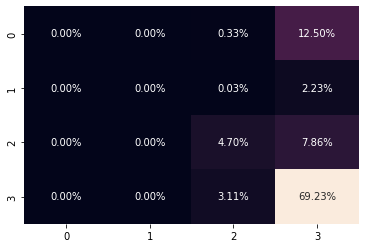

100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


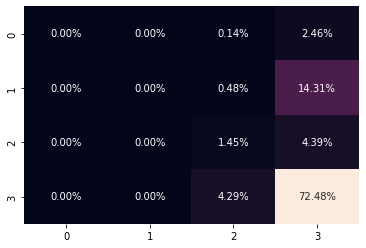


Epoch 12
Training Loss: 0.716500719388326 -----> Training Accuracy: 73.93333333333334 %, Training F1 Score : 0.3242069956093819
Validation Loss: 0.9120685577392578 -----> Validation Accuracy: 73.92771084337349 %, Validation F1 Score : 0.2719582208073257
Validation F1 Inreased(0.2690 ---> 0.2720) 	 Saving The Model


100%|██████████| 18/18 [00:10<00:00,  1.65it/s]


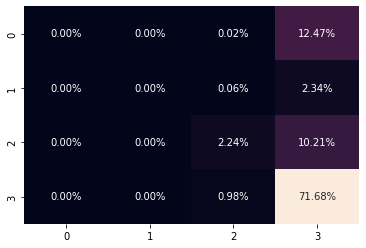

100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


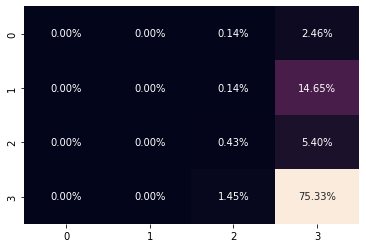


Epoch 13
Training Loss: 0.733566572268804 -----> Training Accuracy: 73.92222222222222 %, Training F1 Score : 0.2828462904723401
Validation Loss: 0.951991856098175 -----> Validation Accuracy: 75.75903614457832 %, Validation F1 Score : 0.2428136504062067


100%|██████████| 18/18 [00:10<00:00,  1.65it/s]


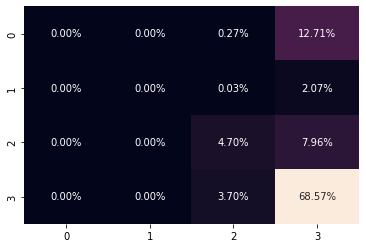

100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


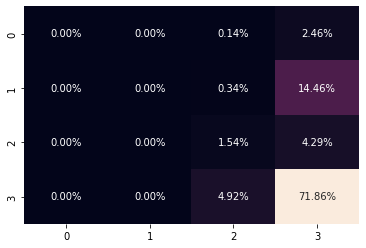


Epoch 14
Training Loss: 0.7229429218504164 -----> Training Accuracy: 73.26666666666667 %, Training F1 Score : 0.3196401560174289
Validation Loss: 0.9116517663002014 -----> Validation Accuracy: 73.39759036144578 %, Validation F1 Score : 0.27192673419998714


100%|██████████| 18/18 [00:10<00:00,  1.64it/s]


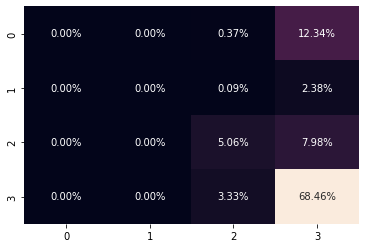

100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


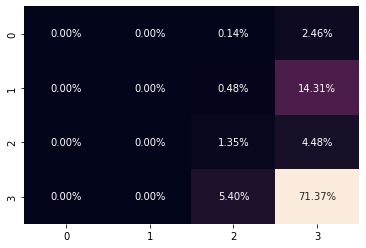


Epoch 15
Training Loss: 0.7066343426704407 -----> Training Accuracy: 73.5111111111111 %, Training F1 Score : 0.32559884482925505
Validation Loss: 0.9522867202758789 -----> Validation Accuracy: 72.72289156626506 %, Validation F1 Score : 0.2617634538110911


100%|██████████| 18/18 [00:11<00:00,  1.62it/s]


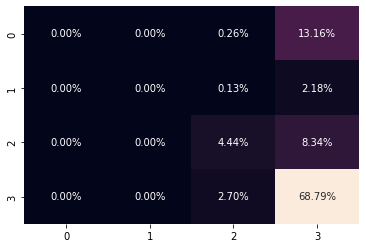

100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


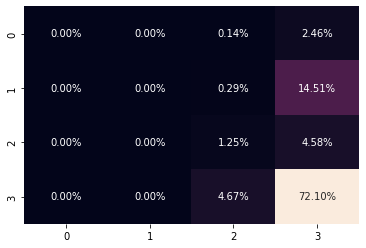


Epoch 16
Training Loss: 0.7094881468349032 -----> Training Accuracy: 73.23333333333333 %, Training F1 Score : 0.31912844416060576
Validation Loss: 0.9953705430030823 -----> Validation Accuracy: 73.34939759036145 %, Validation F1 Score : 0.2629218607479477


100%|██████████| 18/18 [00:11<00:00,  1.63it/s]


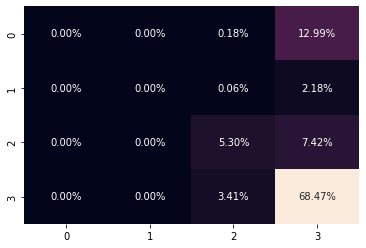

100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


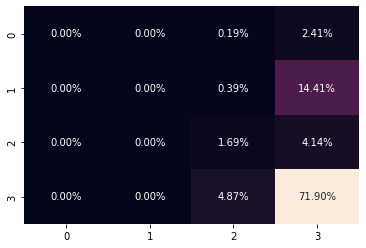


Epoch 17
Training Loss: 0.7046659092108408 -----> Training Accuracy: 73.76666666666667 %, Training F1 Score : 0.3324140752864157
Validation Loss: 0.9502150774002075 -----> Validation Accuracy: 73.59036144578313 %, Validation F1 Score : 0.27698758026360254
Validation F1 Inreased(0.2720 ---> 0.2770) 	 Saving The Model


100%|██████████| 18/18 [00:10<00:00,  1.64it/s]


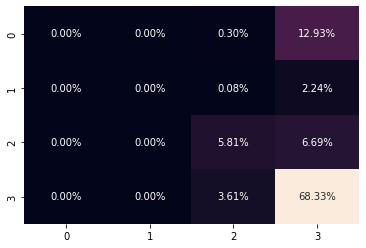

100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


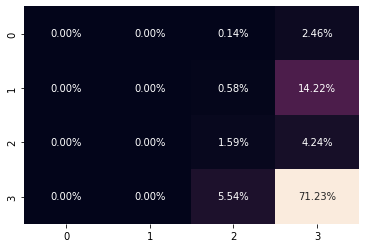


Epoch 18
Training Loss: 0.6900029944048988 -----> Training Accuracy: 74.14444444444445 %, Training F1 Score : 0.34101143837997827
Validation Loss: 0.9369343519210815 -----> Validation Accuracy: 72.81927710843374 %, Validation F1 Score : 0.26894024632818303


100%|██████████| 18/18 [00:11<00:00,  1.64it/s]


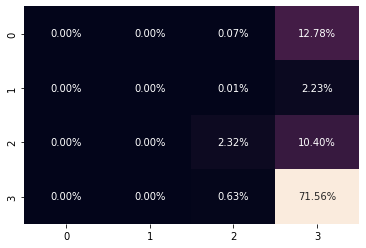

100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


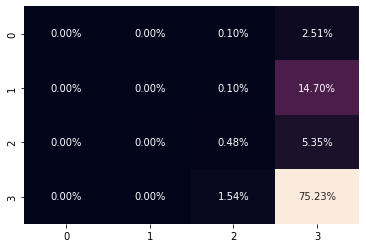


Epoch 19
Training Loss: 0.6915053692128923 -----> Training Accuracy: 73.87777777777778 %, Training F1 Score : 0.2852034905912793
Validation Loss: 0.8786344289779663 -----> Validation Accuracy: 75.71084337349397 %, Validation F1 Score : 0.24542880004761322


100%|██████████| 18/18 [00:11<00:00,  1.62it/s]


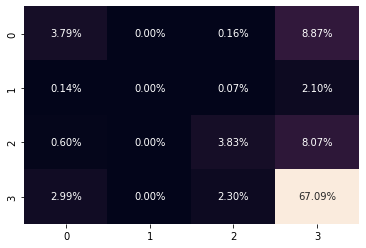

100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


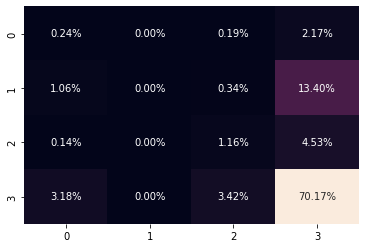


Epoch 20
Training Loss: 0.6544136073854234 -----> Training Accuracy: 74.71111111111111 %, Training F1 Score : 0.4064562429098707
Validation Loss: 0.9165537595748902 -----> Validation Accuracy: 71.56626506024097 %, Validation F1 Score : 0.2795704951731653
Validation F1 Inreased(0.2770 ---> 0.2796) 	 Saving The Model


In [29]:
train_error = []
val_error = []
val_f1 = []
train_f1 = []
val_acc = []
train_acc = []
model.train()
min_val_f1 = -1 * np.inf

for epoch in range(20):
    train_loss = 0.0
    for (text, entity, role) in tqdm(loader):
        model.train()
        text = text.to(device=device, dtype = torch.int32)
        entity = entity.to(device=device, dtype = torch.int32)
        labels = role.to(device=device, dtype = torch.int64)
        hidden = [torch.zeros((2, text.shape[0], 128), dtype = torch.float32).to(device=device),
                  torch.zeros((2, text.shape[0], 128), dtype = torch.float32).to(device=device)]        
        y_pred = model(text, entity, hidden)  
        
        optimizer.zero_grad()       
        loss = criterion(y_pred, labels)
        train_loss += loss.item()
    
        loss.backward()
        optimizer.step() 
        
    model.eval()
    val_loss = 0
    with torch.no_grad():            
        for (text, entity, role) in tqdm(val_loader):
            text = text.to(device=device, dtype = torch.int32)
            entity = entity.to(device=device, dtype = torch.int32)
            labels = role.to(device=device, dtype = torch.int64)
            hidden = [torch.zeros((2, text.shape[0], 128), dtype = torch.float32).to(device=device),
                torch.zeros((2, text.shape[0], 128), dtype = torch.float32).to(device=device)]                
            out = model(text, entity, hidden) 
            loss = criterion(out, labels)       
            val_loss += loss.item()
                
    acc_train, f1_train = score(model, loader, device) 
    acc_val, f1_val = score(model, val_loader, device)
    print(f"\nEpoch {epoch+1}")
    print(f'Training Loss: {train_loss/len(loader)} -----> Training Accuracy: {acc_train} %, Training F1 Score : {f1_train}')  
    print(f"Validation Loss: {val_loss/len(val_loader)} -----> Validation Accuracy: {acc_val} %, Validation F1 Score : {f1_val}")
    train_error.append(train_loss/len(loader))
    val_error.append(val_loss/len(val_loader))  
    val_f1.append(f1_val)
    train_f1.append(f1_train)
    val_acc.append(acc_val)
    train_acc.append(acc_train) 

    if min_val_f1 < f1_val:
        print(f'Validation F1 Inreased({min_val_f1:.4f} ---> {(f1_val):.4f}) \t Saving The Model')
        min_val_f1 = f1_val
        
        # Saving State Dict
        torch.save(model.state_dict(), './Baseline-final-model.pth')
    

100%|██████████| 18/18 [00:11<00:00,  1.62it/s]


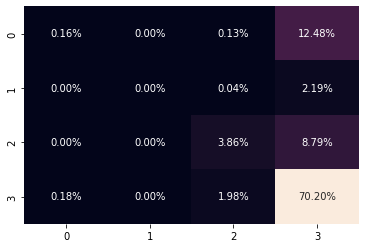

100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


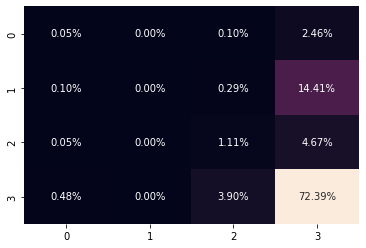


Epoch 1
Training Loss: 0.6847506529755063 -----> Training Accuracy: 74.21111111111111 %, Training F1 Score : 0.3207041846691743
Validation Loss: 0.8783163905143738 -----> Validation Accuracy: 73.5421686746988 %, Validation F1 Score : 0.26873626768388736


100%|██████████| 18/18 [00:11<00:00,  1.61it/s]


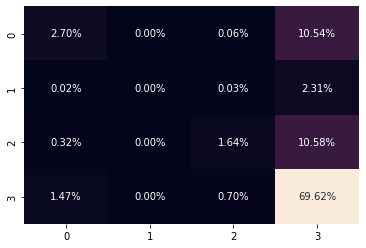

100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


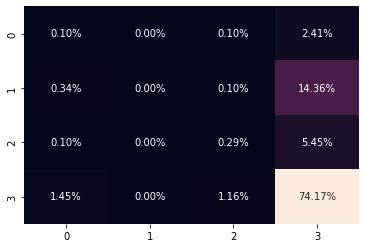


Epoch 2
Training Loss: 0.6682284838623471 -----> Training Accuracy: 73.96666666666667 %, Training F1 Score : 0.34186704509669885
Validation Loss: 0.8360976219177246 -----> Validation Accuracy: 74.55421686746988 %, Validation F1 Score : 0.24404758923335648


100%|██████████| 18/18 [00:10<00:00,  1.64it/s]


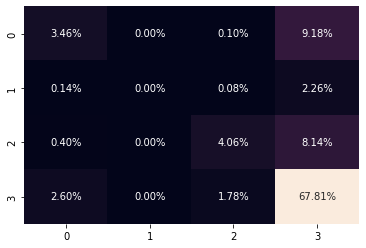

100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


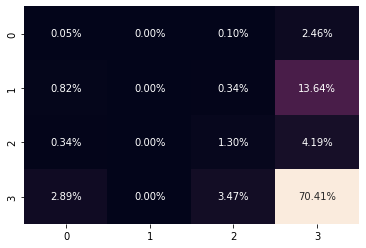


Epoch 3
Training Loss: 0.6570107738176981 -----> Training Accuracy: 75.32222222222222 %, Training F1 Score : 0.4107934479937181
Validation Loss: 0.8277185201644898 -----> Validation Accuracy: 71.75903614457832 %, Validation F1 Score : 0.27276491470578995


100%|██████████| 18/18 [00:11<00:00,  1.63it/s]


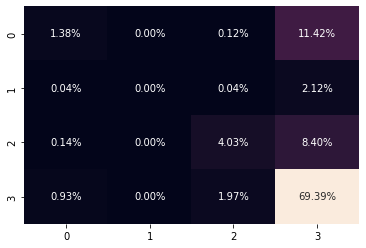

100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


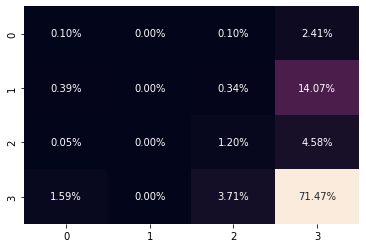


Epoch 4
Training Loss: 0.6332390507062277 -----> Training Accuracy: 74.8 %, Training F1 Score : 0.3642959505864408
Validation Loss: 0.8565201044082642 -----> Validation Accuracy: 72.7710843373494 %, Validation F1 Score : 0.27515654882348123


100%|██████████| 18/18 [00:11<00:00,  1.63it/s]


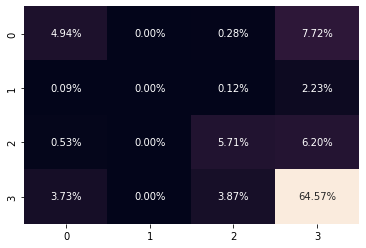

100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


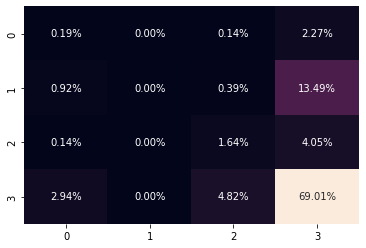


Epoch 5
Training Loss: 0.6612788703706529 -----> Training Accuracy: 75.22222222222223 %, Training F1 Score : 0.4496482000537435
Validation Loss: 0.9345145940780639 -----> Validation Accuracy: 70.8433734939759 %, Validation F1 Score : 0.28647601094728997
Validation F1 Inreased(0.2796 ---> 0.2865) 	 Saving The Model


100%|██████████| 18/18 [00:11<00:00,  1.61it/s]


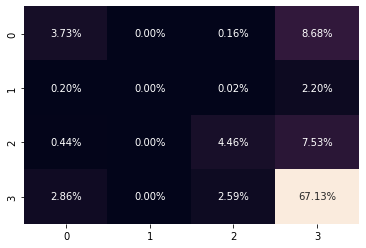

100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


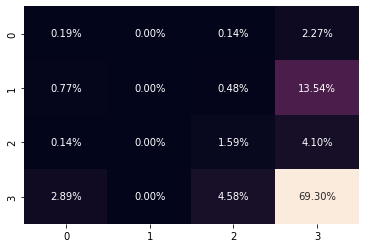


Epoch 6
Training Loss: 0.6432482699553171 -----> Training Accuracy: 75.32222222222222 %, Training F1 Score : 0.41990000888317164
Validation Loss: 0.8618738651275635 -----> Validation Accuracy: 71.08433734939759 %, Validation F1 Score : 0.2863445127856464


100%|██████████| 18/18 [00:11<00:00,  1.63it/s]


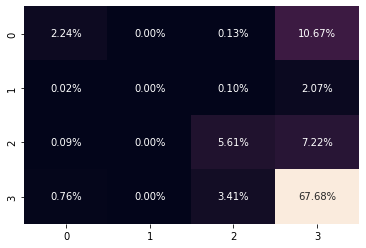

100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


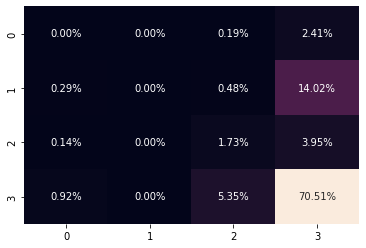


Epoch 7
Training Loss: 0.6543796261151632 -----> Training Accuracy: 75.53333333333333 %, Training F1 Score : 0.40815216063953313
Validation Loss: 0.9111603856086731 -----> Validation Accuracy: 72.24096385542168 %, Validation F1 Score : 0.2740913566505416


100%|██████████| 18/18 [00:11<00:00,  1.63it/s]


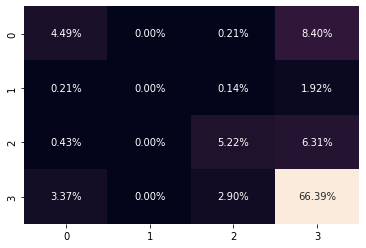

100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


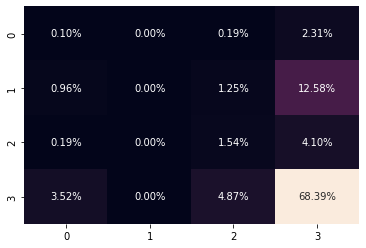


Epoch 8
Training Loss: 0.6608975430329641 -----> Training Accuracy: 76.1 %, Training F1 Score : 0.44485217928545495
Validation Loss: 0.9193463206291199 -----> Validation Accuracy: 70.02409638554217 %, Validation F1 Score : 0.2711828425872456


100%|██████████| 18/18 [00:11<00:00,  1.63it/s]


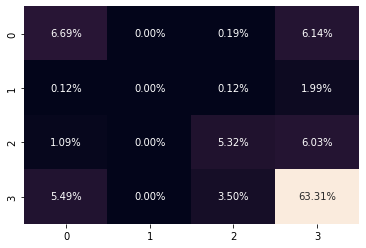

100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


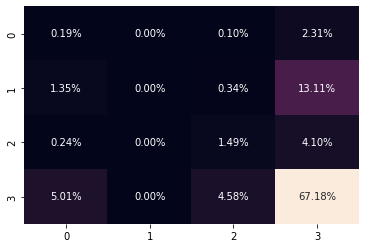


Epoch 9
Training Loss: 0.6421049469047122 -----> Training Accuracy: 75.32222222222222 %, Training F1 Score : 0.46130682206936585
Validation Loss: 0.9179113745689392 -----> Validation Accuracy: 68.86746987951807 %, Validation F1 Score : 0.276286775822448


100%|██████████| 18/18 [00:11<00:00,  1.61it/s]


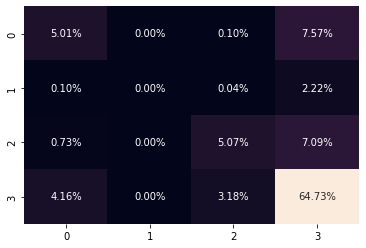

100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


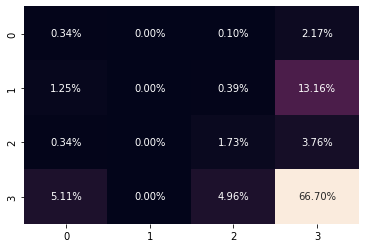


Epoch 10
Training Loss: 0.6366192897160848 -----> Training Accuracy: 74.81111111111112 %, Training F1 Score : 0.44015894704302966
Validation Loss: 0.8525257349014282 -----> Validation Accuracy: 68.7710843373494 %, Validation F1 Score : 0.2893252791777844
Validation F1 Inreased(0.2865 ---> 0.2893) 	 Saving The Model


100%|██████████| 18/18 [00:11<00:00,  1.64it/s]


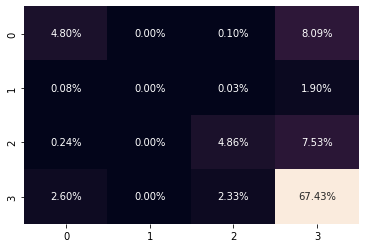

100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


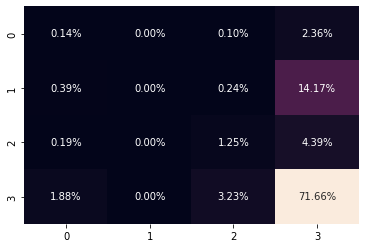


Epoch 11
Training Loss: 0.6318084299564362 -----> Training Accuracy: 77.08888888888889 %, Training F1 Score : 0.45185505385501745
Validation Loss: 0.8769899845123291 -----> Validation Accuracy: 73.06024096385542 %, Validation F1 Score : 0.2842946607593901


100%|██████████| 18/18 [00:11<00:00,  1.61it/s]


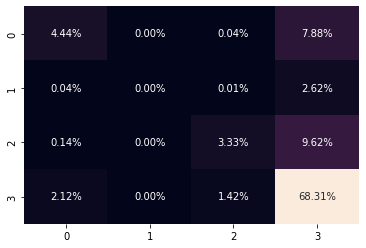

100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


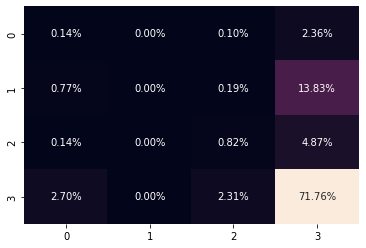


Epoch 12
Training Loss: 0.6217493381765153 -----> Training Accuracy: 76.08888888888889 %, Training F1 Score : 0.42235109505732715
Validation Loss: 0.8749749302864075 -----> Validation Accuracy: 72.72289156626506 %, Validation F1 Score : 0.2672002554315534


100%|██████████| 18/18 [00:11<00:00,  1.61it/s]


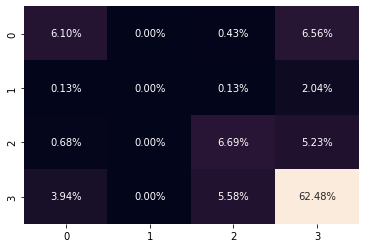

100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


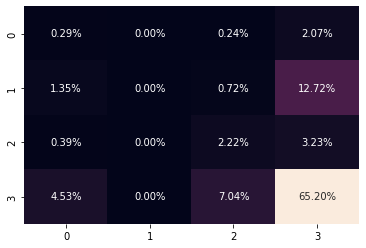


Epoch 13
Training Loss: 0.6407247516844008 -----> Training Accuracy: 75.26666666666667 %, Training F1 Score : 0.4695074673165081
Validation Loss: 0.9441203355789185 -----> Validation Accuracy: 67.71084337349397 %, Validation F1 Score : 0.2886236029942435


100%|██████████| 18/18 [00:11<00:00,  1.58it/s]


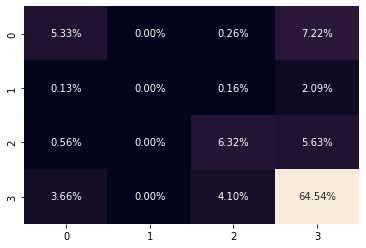

100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


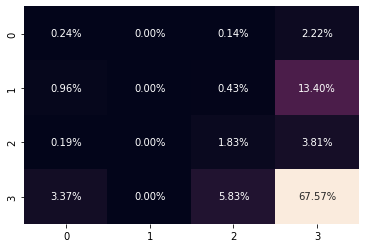


Epoch 14
Training Loss: 0.6366237368848588 -----> Training Accuracy: 76.2 %, Training F1 Score : 0.4666013304746429
Validation Loss: 0.9119078755378723 -----> Validation Accuracy: 69.63855421686748 %, Validation F1 Score : 0.28770618468011205


100%|██████████| 18/18 [00:11<00:00,  1.62it/s]


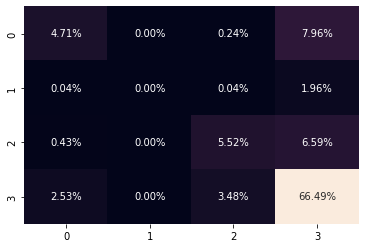

100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


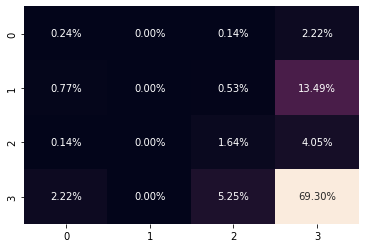


Epoch 15
Training Loss: 0.6266465385754904 -----> Training Accuracy: 76.72222222222223 %, Training F1 Score : 0.45443164904164807
Validation Loss: 0.9243212580680847 -----> Validation Accuracy: 71.18072289156626 %, Validation F1 Score : 0.2902632558295125
Validation F1 Inreased(0.2893 ---> 0.2903) 	 Saving The Model


100%|██████████| 18/18 [00:11<00:00,  1.61it/s]


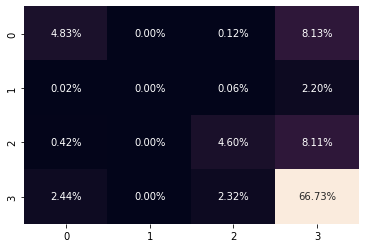

100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


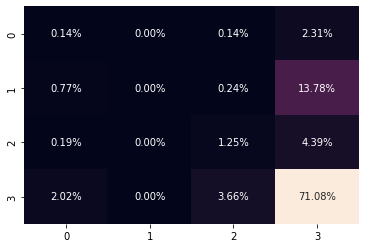


Epoch 16
Training Loss: 0.6110191742579142 -----> Training Accuracy: 76.16666666666667 %, Training F1 Score : 0.4427612906592515
Validation Loss: 0.858089017868042 -----> Validation Accuracy: 72.48192771084338 %, Validation F1 Score : 0.28001865712581264


100%|██████████| 18/18 [00:11<00:00,  1.62it/s]


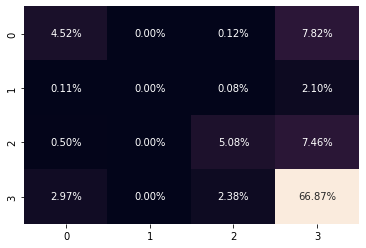

100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


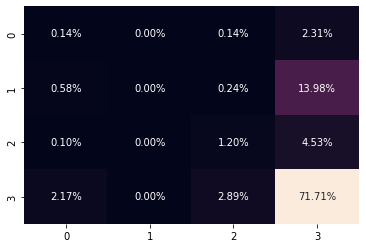


Epoch 17
Training Loss: 0.6199084652794732 -----> Training Accuracy: 76.46666666666667 %, Training F1 Score : 0.4463502900794098
Validation Loss: 0.9777530550956726 -----> Validation Accuracy: 73.06024096385542 %, Validation F1 Score : 0.2831270487528529


100%|██████████| 18/18 [00:10<00:00,  1.65it/s]


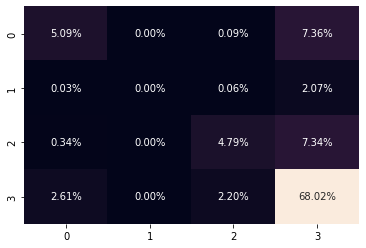

100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


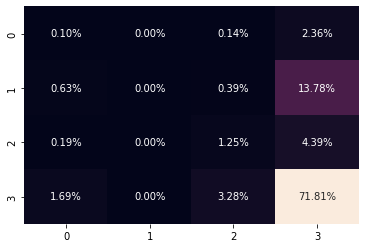


Epoch 18
Training Loss: 0.6209710008568234 -----> Training Accuracy: 77.9 %, Training F1 Score : 0.461322569350088
Validation Loss: 0.8561557054519653 -----> Validation Accuracy: 73.1566265060241 %, Validation F1 Score : 0.2790925829250794


100%|██████████| 18/18 [00:11<00:00,  1.63it/s]


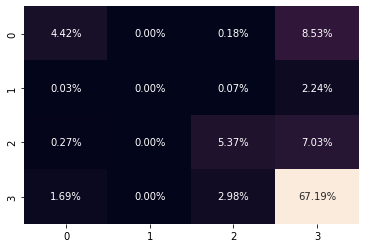

100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


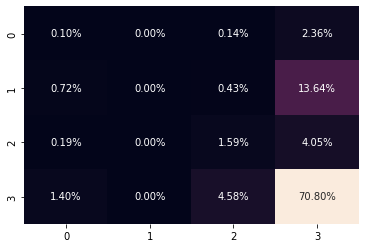


Epoch 19
Training Loss: 0.6304680903752645 -----> Training Accuracy: 76.97777777777777 %, Training F1 Score : 0.45354836677466936
Validation Loss: 0.8775591254234314 -----> Validation Accuracy: 72.48192771084338 %, Validation F1 Score : 0.2840183642641456


100%|██████████| 18/18 [00:10<00:00,  1.64it/s]


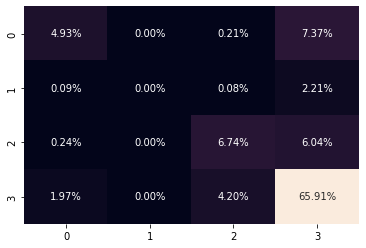

100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


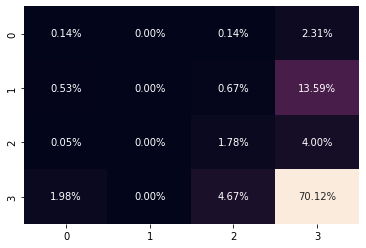


Epoch 20
Training Loss: 0.6212590932846069 -----> Training Accuracy: 77.58888888888889 %, Training F1 Score : 0.4784337370326949
Validation Loss: 0.9051311254501343 -----> Validation Accuracy: 72.04819277108433 %, Validation F1 Score : 0.29185043386428144
Validation F1 Inreased(0.2903 ---> 0.2919) 	 Saving The Model


In [30]:
for epoch in range(20):
    train_loss = 0.0
    for (text, entity, role) in tqdm(loader):
        model.train()
        text = text.to(device=device, dtype = torch.int32)
        entity = entity.to(device=device, dtype = torch.int32)
        labels = role.to(device=device, dtype = torch.int64)
        hidden = [torch.zeros((2, text.shape[0], 128), dtype = torch.float32).to(device=device),
                  torch.zeros((2, text.shape[0], 128), dtype = torch.float32).to(device=device)]        
        y_pred = model(text, entity, hidden)  
        
        optimizer.zero_grad()       
        loss = criterion(y_pred, labels)
        train_loss += loss.item()
    
        loss.backward()
        optimizer.step() 
        
    model.eval()
    val_loss = 0
    with torch.no_grad():            
        for (text, entity, role) in tqdm(val_loader):
            text = text.to(device=device, dtype = torch.int32)
            entity = entity.to(device=device, dtype = torch.int32)
            labels = role.to(device=device, dtype = torch.int64)
            hidden = [torch.zeros((2, text.shape[0], 128), dtype = torch.float32).to(device=device),
                torch.zeros((2, text.shape[0], 128), dtype = torch.float32).to(device=device)]                
            out = model(text, entity, hidden) 
            loss = criterion(out, labels)       
            val_loss += loss.item()
                
    acc_train, f1_train = score(model, loader, device) 
    acc_val, f1_val = score(model, val_loader, device)
    print(f"\nEpoch {epoch+1}")
    print(f'Training Loss: {train_loss/len(loader)} -----> Training Accuracy: {acc_train} %, Training F1 Score : {f1_train}')  
    print(f"Validation Loss: {val_loss/len(val_loader)} -----> Validation Accuracy: {acc_val} %, Validation F1 Score : {f1_val}")
    train_error.append(train_loss/len(loader))
    val_error.append(val_loss/len(val_loader))  
    val_f1.append(f1_val)
    train_f1.append(f1_train)
    val_acc.append(acc_val)
    train_acc.append(acc_train) 

    if min_val_f1 < f1_val:
        print(f'Validation F1 Inreased({min_val_f1:.4f} ---> {(f1_val):.4f}) \t Saving The Model')
        min_val_f1 = f1_val
        
        # Saving State Dict
        torch.save(model.state_dict(), './Baseline-final-model.pth')
 

In [31]:
df_train = pd.DataFrame({"Accuracy" : train_acc, "Loss" : train_error, "F1 Score" : train_f1})
df_val = pd.DataFrame({"Accuracy" : val_acc, "Loss" : val_error, "F1 Score" : val_f1})
df_train.to_csv(r"./Baseline-train-Metrics.csv", index = False)
df_val.to_csv(r"./Baseline-val-Metrics.csv", index = False)

<h2>Visualizing results

In [2]:
!gdown --id 1nLUvjMqfluxrGYSO4J1Sx8Baur2H8lNs #train df
!gdown --id 1gvpQIkVV8H6fR48-eyK5ytSruDX8BoY1 #val df

df_train = pd.read_csv(r"./Baseline-train-Metrics.csv")
df_val = pd.read_csv(r"./Baseline-val-Metrics.csv")

import matplotlib.pyplot as plt
def plot(x, y1, y2, x_label, y_label, y1_label, y2_label):
  plt.figure(figsize=(8, 6))
  plt.plot(np.arange(1, x + 1, 1), y1, marker='o', color = 'b', label = y1_label)
  plt.plot(np.arange(1, x + 1, 1), y2, marker='o', color = 'r', label = y2_label)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.legend()
  plt.show()

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1nLUvjMqfluxrGYSO4J1Sx8Baur2H8lNs
To: /content/Baseline-train-Metrics.csv
100% 2.19k/2.19k [00:00<00:00, 3.70MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1gvpQIkVV8H6fR48-eyK5ytSruDX8BoY1
To: /content/Baseline-val-Metrics.csv
100% 2.27k/2.27k [00:00<00:00, 3.16MB/s]


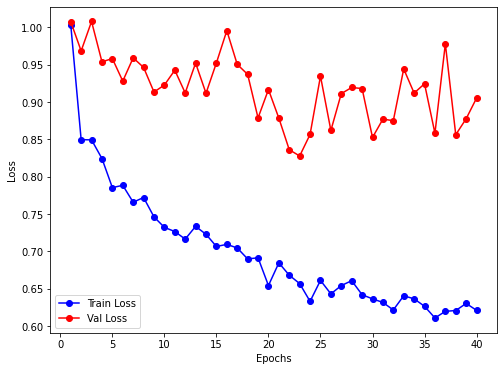

In [3]:
plot(len(df_val), df_train['Loss'], df_val['Loss'], "Epochs", "Loss", "Train Loss", "Val Loss")

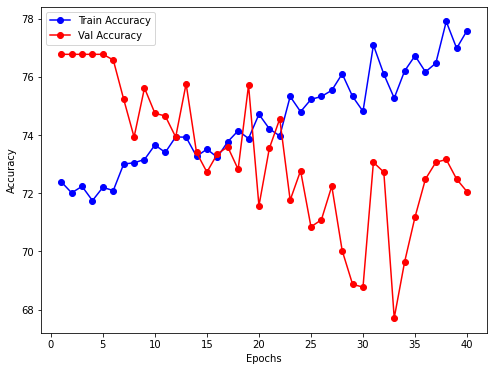

In [34]:
plot(len(df_val), df_train['Accuracy'], df_val['Accuracy'], "Epochs", "Accuracy", "Train Accuracy", "Val Accuracy")

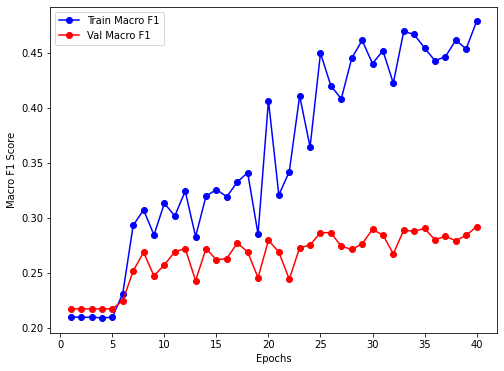

In [35]:
plot(len(df_val), df_train['F1 Score'], df_val['F1 Score'], "Epochs", "Macro F1 Score", "Train Macro F1", "Val Macro F1")

In [10]:
import pandas as pd
results = pd.DataFrame(columns = ['Loss', 'Accuracy', 'Macro F1'], 
                   index = ['Sampled Train', 'Val', 'Test'])
results.loc['Sampled Train'] = [0.62, 77.58, 47.84]
results.loc['Val'] = [.90, 72.04, 29.18]
results.loc['Test'] = [0.84, 74.23, 30.88]
results

,Loss,Accuracy,Macro F1
Sampled Train,0.62,77.58,47.84
Val,0.9,72.04,29.18
Test,0.84,74.23,30.88
